# **Project 2 - Genetic Algorithm for Image Reconstruction.**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Eduardo Barros Innarelli - RA 170161
    Victor Ferreira Ferrari  - RA 187890
    Vinicius Couto Espindola - RA 188115

## **Introduction**
### Project
The project consists of a study of genetic algorithm-based solutions for **image reconstruction**. A few set aspects of the problem will be explained, implemented and discussed here, such as:

- The **modeling** of the problem as an evolutionary problem (chromosomes, genes, etc);
- How to **generate the initial population**;
- The chosen **fitness function**;
- How to **visualize** the result.

Along with that, some aspects of the genetic algorithm will be tested and discussed with multiple approaches, such as:

- Stop criteria;
- Selection technique;
- Crossover technique;
- Mutation technique;
- Generation replacement method.

Also, the following **parameters** will be tested with multiple values as well:
- Population size;
- Mutation rate;
- Crossover rate.

In the end, different variations of the process will be compared and discussed.

### Usage

This project uses the external libraries _OpenCV_ for image reading and manipulation, _NumPy_ for array manipulation, _Scikit-Learn_ for error calculations, and _MatPlotLib_ for result visualization. The other imports are part of the Standard Python Library.

In [1]:
# External Libraries
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from cv2 import imread, imwrite, resize
import numpy as np

# Python Libraries
from random import sample, choices
from os.path import join, basename

## **Problem**
### General Information
The problem consists of, given an image, recreate it from scratch, using the original image only for fitness purposes, to check the similarity between our image and the original. This is not particularly useful in many applications, but can be used as basis for other problems, and is good for the purpose of this project: test different methods of reproduction, mutation, etc.

The motivation came from [Roger Johansson's "Evolution of Mona Lisa"](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/), but instead of using polygons, the pixel values are directly used.

### Modeling
The modeling of the problem as a GA problem is almost direct: the image is the individual (chromosome) and each of its pixels is a gene. The image can be represented by a multitude of different ways. The chosen way of representation is as a flat array, as this allows for easier operations, especially crossover.

### Inputs
Due to the huge number of combinations in an image (255 possiblities per pixel), greyscale images are used in this project. Low-resolution images are best for this, but there are methods of reducing the resolution using _OpenCV_.

## **Methods**

### Notes on Structure

The code was organized in such a manner which allows us to first define every method used as well as discuss them in separated modules, making each part more readable and comprehesible.

In order to merge all components of the code we created a class called GeneticAlgorithm. This class retains some essential variables for the methods defined along the report. In order to allow the methods to access these variables even though they are not a part of the class, every single method must receive as it's first parameter the class instance, prepended into every parameter list.

### Population Initialization

The first step to run a genetic algorithm is creating a population to serve as a starting point for the selection, reproduction and mutation process. This function also handles the initilization of the current best population, the best population overall fitness and best individual fitness, which are paramount for convergence check and final results.   

Every method in this section will be subdued by the following parameters:
 1. **fitness:** Used to calculate to initialize population score and best individual.
 2. **pop_size:** Defines the maximum amount of individuals for the population.
 
**Note:** The amount of genes in each individual is defined by the goal variables in the class. These variables store information of the image we aim to generate, including the amount of pixels (which are the genes in our model).

The following code defines some methods which will be used to create a population out of nothing.

In [2]:
def random(self, pop_size):
    # Generate completely random indivuduals 
    self.population = []
    size = self.goal.size
    
    for i in range(pop_size):
        print(f"Generating Population...  {i:>3}/{pop_size}\r", end='')
        person = np.random.randint(0, 255, size, dtype=np.uint8)
        self.population.append(person)
    self.pop_size = pop_size
    print(f"{' '*50}\r", end='')

In [3]:
def white(self, pop_size):
    self.population = []
    size = self.goal.size

    for i in range(pop_size):
        print(f"Generating Population...  {i:>3}/{pop_size}\r", end='')
        person = np.full(size, 255, dtype=np.uint8)
        self.population.append(person)
    self.pop_size = pop_size
    print(f"{' '*50}\r", end='')

### Fitness Function
**Responsible: Victor**

For each individual, we must determine a method which will tell us how apt such individual for the problem in question.

The following methods define some method to evaluate how close is an individual to the image we seek to generate.

In [4]:
def mse(individual, original):
     return mean_squared_error(original.astype(np.float64), individual.astype(np.float64))

In [5]:
def correct_pixels(individual, original):
    return np.count_nonzero(original.astype(np.int16) - individual.astype(np.int16))

### Convergence Criteria

The algorithm cannot run forever. In this section will define a convergence method for halting the program's exection. 

The convergence function must identify when the algorithm's improvement rate has significantly decreased or even stalled. To do so, it must know the overall quality of the current population, which can be easily calculated with the sum of every indivudual's fitness score. Let's call this overall finess the generation fitness. We can estimate when the algorithm is decreasing it's evolution rate (or improvement rate) by checking how many generations have passed since the best generation so far was achieved: the more unimproved generations, the more likely is has converged. This is what the convergence method will do.

**Note:** even checking for convergence, the algorithm might still present sufficiently small improvements to avoid convergence, however, they might be so small that it will take a enormous amount of time to converge. As a failsafe to this scenario, we will limit the total amount of generations that can be created from withing the GeneticAlgorithm class.

In [6]:
def convergence(self, limit):
    ''' Identifies convergence and updates fittest individual found so far 
        
        Parameters:
            self - GeneticAlgorithm class which the function is being called from
            limit - Amount of iterations wich can be worst than the best one found so far
        Return:
            Bool - True if converged, False otherwise.
    '''
    # Get min fitness for population
    new_genfit = self.all_fits.min()
     
    # Update number of iterations without improvement
    if new_genfit >= self.best_genfit:
        self.counter += 1
    else:
        self.counter = 0
        self.best_genfit = new_genfit
    
    # Check convergence
    if self.counter >= limit or self.best_genfit <= 0:
        self.counter = 0
        return True
    else:
        return False 

### Parents Selection

In this section we'll define methods responsible for selecting individual of the population responsible for bearing the next generation.

Every method in this section will be subdued by the following parameters:
 1. **P:** Defines the probability of accepting a certain idividual.
 2. **N:** Amount of couples to be selected for mating.
 3. **K:** Amount of individuals to partake in a competition.
 
The following code defines some methods which will be used to select individual for the creation of the next generation.

In [7]:
# if the tournament size is larger, weak individuals have 
# a smaller chance to be selected, because, if a weak 
# individual is selected to be in a tournament, there is 
# a higher probability that a stronger individual is also 
# in that tournament.

def tournament(self, k, N):
    pool = np.arange(self.pop_size)
    pairs = {x:set() for x in pool}
    fitness = lambda x: self.all_fits[x]
    winners,self.mates = [],[]

    for i in range(N//2):
        competitors = np.random.choice(pool, size=k, replace=False)
        winner = max(competitors, key=fitness)
        winners.append(winner)
        pool.remove(winner) # remove winner from pool
    
    # Combination: given a pool of winners, pairs then in couples
    #  - Each individual can mate with at most two other individuals
    #  - Each individual cannot mate twice with some individual
    #  - Each individual cannot mate with himself
    # This combination generates 2*N pairs with the previous restrictions
    while winners:
        # Picks a father and remove any mate which he was already paired with
        dad = np.random.choice(winners)
        for m in pairs[dad]: winners.remove(m)
            
        # Picks a mother and returns the removed pairs to the winners pool
        mom = np.random.choice(winners)
        for m in pairs[dad]: winners.append(m)
        
        # Update the couples for reproduction
        self.mates.append((dad,mom))
        
        # Only allows the selected couple to participate again if they haven't
        # mated with 2 or more individuals.
        if len(pairs[dad]) < 2: winners.append(dad)
        if len(pairs[mom]) < 2: winners.append(mom)

In [8]:
def ranked(self):
    fit = self.all_fits
    size = self.pop_size
    
    # Roulette method: select N/2 individuals from the population,
    # with proportional probabilities to their fitness values.
    probs = np.absolute(fit/fit.sum())
    probs /= probs.sum()
    winners = np.random.choice(np.arange(size), size=size//2, replace=True, p=probs)    
    
    self.mates = list(zip(winners[::2],winners[1::2]))

### Crossover Techniques

In this section we'll define methods that generate descendants from selected parents. 

Based on genetic recombination, crossover exchanges genes between two individuals in a stochastic manner, resulting in a new one. Computationally, the way genes are swapped depends on the method implemented. By reproducting, the population preserves genetic diversity between generations.

In [9]:
def k_point_crossover(self, k):
    ''' 
    For each couple, K points are picked randomly from their chromossomes and
    genes between these points are swapped, intercalating pairs of points.
    
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
        k - Amount of crossover points for gene exchange
    '''
    
    num_genes = self.goal.size
    self.children = []

    for father, mother in self.mates:
        # Save k unique random crosspoints in a sorted list
        crosspoints = sorted(sample(range(0, num_genes-1), k))
        
        # Deep copy to freely change values
        father = self.population[father].copy()
        mother = self.population[mother].copy()
        
        # List of crosspoint pairs, adding a pair with last crosspoint
        # and last pixel
        # Ex: 
        # 16 pixels, points [1,9,12] -> pairs [(1,9), (9,12), (12,16)]
        pairs = list(zip(crosspoints,crosspoints[1:]))
        pairs.append(tuple((crosspoints[-1], num_genes)))

        # Perform crossover in pair range, intercalating pairs
        for start, end in pairs[::2]:
            father[start:end], mother[start:end] = mother[start:end], father[start:end]
        
        self.children   += [father, mother]

In [10]:
def uniform_crossover(self, exchange_prob):
    '''
    For each couple, it's genes are exchanged with a given probability.
    
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
        exchange_prob - Probability of gene being exchanged between parents
    '''
    
    num_genes = self.goal.size
    self.children = []
    
    for father, mother in self.mates:
        
        # Deep copy to freely change values
        father = self.population[father].copy()
        mother = self.population[mother].copy()
        
        # Exchange genes with a given probability
        for gene in range(num_genes):
            if np.random.uniform() < exhange_prob:
                father[gene], mother[gene] = mother[gene], father[gene]
                
        self.children   += [father, mother]

### Mutation Method
**Responsible: Victor**

To simply permute the genes of the previous generation might reduce the diversity among individuals by creating childs which are too similar to their parents. To counter this we'll use mutation methods allowing genes to mix within individuals. 

Every method in this section will be subdued by the following parameters:
 1. **MR:** Mutation rate dictates the probability of an individual to mutate.
 2. **MA:** Mutation amount defines the amount of genes which will mutate.
 
The following code defines some methods which will be used to mutate the individuals.

In [11]:
def random_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(0, 255, gene_amount, np.uint8)
        i[genes] = new # Changes are in-place

In [12]:
def reduced_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(0, 31, gene_amount, np.uint8)
        i[genes] = new*8 # Changes are in-place

In [13]:
def inc_mut(self, MR, MA):
    # Set some synonyms
    size = self.goal.size
    pop  = self.children
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop)) # amount of individuals to mutate
    individuals = choices(pop, k=mut_amount)
    
    # Change elements to random value.
    gene_amount = int(MA*size) # amount of genes to mutate per individual
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new   = np.random.randint(-10, 10, gene_amount, np.int8)
        i[genes] += new # Changes are in-place

### Replacement Techniques

In this stage we're storing both the parents and their children. Increasing the population size can affect the algorithm performance in terms of memory usage and time as well as the convergence rate due to unfit individuals being kept alive. To mitigate this, it's necessary to choose which individuals will remain in the new generation.

In [32]:
def elitism(self):
    ''' 
    Preserve the fittest individuals between both parents and children
        
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
    '''
    
    # Calculate children fitness.
    generator = map(lambda x: self.fit(x, self.goal), self.children)
    all_fits = np.concatenate((self.all_fits, np.array(list(generator), dtype=np.float64)))
    
    # Sort fits and population by fits.
    idxs = all_fits.argsort()
    full = self.population + self.children
    full = np.array(full)
    
    # Combine parents with children, sorted by fitness function
    combined = full[idxs]
    all_fits = all_fits[idxs]
    
    # Update population with the fittest individuals
    self.population = list(combined[:self.pop_size])
    self.all_fits = all_fits[:self.pop_size]

In [15]:
def steady_state(self):
    ''' 
    Children replaces the least fit parents.
    
    Obs: if number of children and parents are equal, this have the same
    effect as a generational replacement.
    
    Parameters:
        self - GeneticAlgorithm class which the function is being called from
    '''
    
    pop_sorted = sorted(range(self.pop_size), key = lambda x: self.all_fits[x])
    
    # Replace worst fits from population with childs
    while self.children and pop_sorted:
        old = pop_sorted.pop()
        new = self.children.pop()
        self.population[old] = new
        self.all_fits[old] = self.fit(new, self.goal)

## **Genetic Algorithm Class**

The class will be responsible for selecting which methods will be used for each of the methods in each of the algorithms steps, as well as define it's parameters and executing the main loop. The main loop will be responsible for properly calling the methods, any in between tasks as wells as check halting conditions and picking the fittest individual found in all generations.

##### Preprocessing and Visualization Method
To perceive empirically if the quality of each generation as well as the final result, we will use openCV to exhibit the image represented by some individual.

##### Fitness Update Method
There are multiple steps in which we must use the fitness of every individual in the population, to avoid overhead, we'll define a function which will take care of updating the fitness values list. Calling it only once or twice (depending on the method for survivors selection) to avoid overhead.


In [30]:
class GeneticAlgorithm():
    ''' The GeneticAlgorithm class retains and coordinates all necessary variables and methods
        for the execution of the genetic algorithm created.
        It's initialization receives the methods which will compute each step of the algorithm
        as well as the parameters utilized by each of these methods. A limit integer is also
        define to halt the programs execution.
        
        Methods:
            run    - execute the genetic algorithm based on the instance variables/methods
            update - recalculate individuals fitness and updates best individual so far
            read   - read a image from file, rescale and flatten
            show   - reshape flattened image and exhibit with matplotlib
    '''
    
    def __init__(self, 
                 limit     = 10000, # Max amount of generations to create
                 fit       = None,  # Function to calculate individual fitness
                 conv      = None,  # Convergence function and parameters
                 init      = None,  # Population Initializer function and parameters
                 mating    = None,  # Population Selection function and parameters
                 crossover = None,  # Selected Indviduals Crossover function and parameters
                 mutate    = None,  # Selected Indviduals Mutation function and parameters
                 replace   = None,  # Choose which individuals are kept/replaced
                ):
        
        # Halting criterias
        self.counter = 0 # Convergence counter
        self.limit = limit
        self.abort = lambda: bool(self.gen_count >= self.limit)
        
        # Goal related variables
        self.shape = None # Holds original downsized image shape
        self.goal  = None # Holds an array with the ideal individual (goal image)
        
        # Convergence related variables
        self.best        = None         # Best individual obtained so far
        self.best_fit    = float('inf') # The fit score of the bets individual so far
        self.all_fits    = None         # List of each individual fitness
        self.best_gen    = None         # Best generation.
        self.best_genfit = float('inf')
        
        # Generation related variables
        self.pop_size   = None  # The amount of individuals kept per generation
        self.population = None  # List of individual of the current generation
        self.gen_count  = 1     # Current generation (first, second, ...)
        self.mates      = None  # Paired individuals which will reproduce
        self.children   = []
    
        # Static Genetic Methods Functions
        self.fit = fit
        define = lambda x: lambda: x[0](self,*x[1]) if x[1] else x[0](self)
        self.conv   = define(conv)
        self.init   = define(init)
        self.mating = define(mating)
        self.crossover = define(crossover)
        self.mutate = define(mutate)
        self.replace = define(replace)
        # TODO: MR needs to decrease with time to converge.
        
        test = [self.conv,self.init,self.mating,self.crossover,self.mutate]
        test = all(map(bool, test))
        assert test, "There are undefined steps for the algorithm"
    
    def test(self, img_path):
        self.read(img_path, res=0.6)
        self.init()
        
        generator = map(lambda x: self.fit(x, self.goal), self.population)
        self.all_fits = np.array(list(generator), dtype=np.float64)
        
        while not (self.conv() or self.abort()):
            print(f"Current Generation: {self.gen_count:>6}. Current Best: {self.best_fit:>8.3f} (gen {self.best_gen}).\r", end='')
            
            self.mating()     # Generate tuples indicating mating pairs
            self.crossover()  # Generate two childs for each couple
            self.mutate()     # Apply mutation on all individuals (old and new)
            self.replace()    # Select which individuals will be kept
            
            self.gen_count += 1
            self.update()
            continue
            
        self.counter = 0
        self.show(self.best, compare=True)
        
    def update(self):
        ''' Updates the fitness of every individual in the population.
            Also updates the fittest individual found among all generations.
        '''
        # Update fittest individual
        idx = np.argmin(self.all_fits)
        if self.all_fits[idx] < self.best_fit: 
            self.best     = self.population[idx].copy() # save best inividual
            self.best_gen = self.gen_count
            self.best_fit = self.all_fits[idx]

    def read(self, filepath, res=None):
        '''Reads an image in grey scale, resizes it and extends to array.
            Params:
                filepath - Path to the input image to be read
                res - Either tuple with new pixel dimensions or ratio with new scale
            Return: 
                np.array - array with the streched image
        '''
        img = imread(filepath,0) # load in greyscale
        
        if res and tuple==type(res):
            img = resize(img, res)
        elif res and float==type(res):
            w = int(img.shape[0]*res)
            h = int(img.shape[1]*res)
            img = resize(img, (h,w))
            
        self.shape = img.shape # keep shape
        self.goal  = img.reshape(img.size)

    def show(self, individual, compare=False):
        '''Prints the image represented by an individual.
            Params:
                individual - Np.array to be reshaped and printed
        '''
        plt.figure(figsize=(15,15))
        
        # If compare mode, print goal along side
        if compare: 
            plt.subplot(1,2,2)
            goal = self.goal.copy()
            goal = goal.reshape(self.shape)
            plt.imshow(goal, cmap='gray')
            plt.title('Goal')
            plt.axis('off')
            plt.subplot(1,2,1)
            
        img = individual.copy()
        img = img.reshape(self.shape)
        plt.imshow(img, cmap='gray')
        plt.title('Individual')
        plt.axis('off')
        plt.show() 
    
    def write(self, individual, path, folder='Outputs'):
        name = g + str(self.gen_count) + '_' + basename(path)
        imwrite(join(folder, name), individual)

## **Tests**

Now that a few variations of each technique are implemented, it's possible to test multiple combinations of those methods and other parameters, and compare the final results.

As previously mentioned, the test cases are **small**, **monochromatic** images. This is due to the amount of possibilities per individual, the convergence can be very slow if the pixel count is too large.

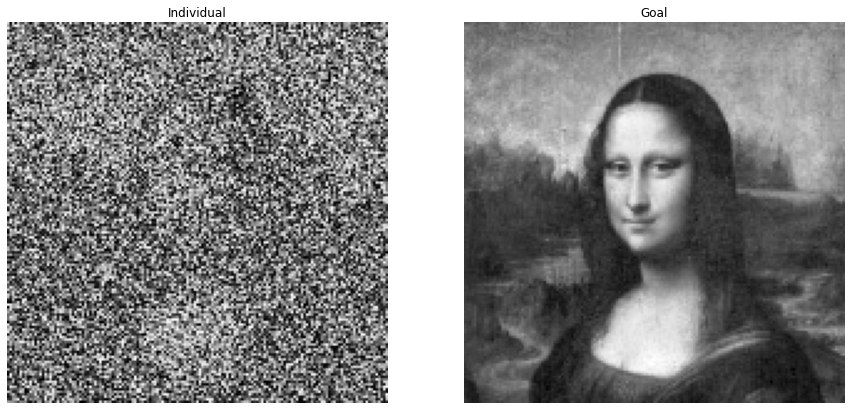

In [37]:
ga = GeneticAlgorithm(
    limit     = 100000,
    fit       = mse,
    conv      = (convergence,(1000,)), 
    init      = (random,(50,)),
    mating    = (ranked,None), 
    crossover = (k_point_crossover,(3,)), 
    mutate    = (reduced_mut,[0.05,0.025]), # Tip higher MR and lower MA
    replace   = (elitism,None)
    )

ga.test('images/monalisa.png')

## **Result Analysis and Comparisons**

## **Conclusions**

As mentioned previously, the amount of possibilities makes this a hard problem to solve, especially for higher resolution images.